# HAPPINESS
___

STAT 201 - Group 12: Anne Nguyen, Eric Pien, Oliver Gullery, Ruby Yang




## Introduction
___

Happiness can be said to be a subjective assessment of an individual’s emotion state/life satisfaction. Many factors can influence a person’s life satisfaction such as health, income, and social network. As a result, happiness can often act as an indicator for societal well-being (1). We aim to investigate how external events, such as the COVID-19 pandemic, can affect this indicator on the world population. Ultimately, we hope to answer the question: **Did Covid-19 impact levels of happiness**?

We will be using data from the *World Happiness Report* (2) where happiness score is assessed using the Cantril ladder – a tool used to measure a person’s subjective well-being. The score ranges from 0 to 10, representing the worst and the best possible life respectively. We will compare the `mean` and `standard deviation` in happiness score for years before and after the COVID-19 pandemic.  


## Preliminary Result ##
___

### Data Loading, Cleaning, Splitting ###

In [1]:
# Environment Setup
library(tidyverse)
library(tidymodels)
library(GGally)
library(gridExtra)
library(janitor)
library(cowplot)

options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.4     ✔ yardstick    1.1.0
✔ recipes      1.0.3     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ 

In [2]:
# Read data from the web into R
data <- read_csv('https://raw.githubusercontent.com/ericpien/stat-201-project/main/data/DataForTable2.1.csv',skip=0)

# Clean/Wrangle Data
happiness_data <- data |>
    clean_names() |>
    as_tibble() |>
    drop_na()

# Create n_tile clusters by the year
n_tile <- 4

happiness_data <- happiness_data |>
    group_by(year) |>
    mutate(life_ladder_ntile = ntile(-life_ladder,n_tile),
            log_gdp_per_capita_ntile = ntile(-log_gdp_per_capita,n_tile),
            social_support_ntile = ntile(-social_support,n_tile),
            healthy_life_expectancy_at_birth_ntile = ntile(-healthy_life_expectancy_at_birth,n_tile),
            freedom_to_make_life_choices_ntile = ntile(-freedom_to_make_life_choices,n_tile),
            generosity_ntile = ntile(-generosity,n_tile),
            perceptions_of_corruption_ntile = ntile(-perceptions_of_corruption,n_tile),
            positive_affect_ntile = ntile(-positive_affect,n_tile),
            negative_affect_ntile = ntile(-negative_affect,n_tile),
            confidence_in_national_government_ntile = ntile(-confidence_in_national_government,n_tile))

# Create wide dataframe of mean happiness
happiness_data_wide_life_ladder <- happiness_data |> 
    group_by(country_name,year) |>
    summarize(life_ladder = life_ladder) |>
    pivot_wider(names_from = year,
                values_from = life_ladder)

Rows: 2089 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Country name
dbl (11): year, Life Ladder, Log GDP per capita, Social support, Healthy lif...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'country_name'. You can override using the
`.groups` argument.


### Preliminary Data Exploration ###

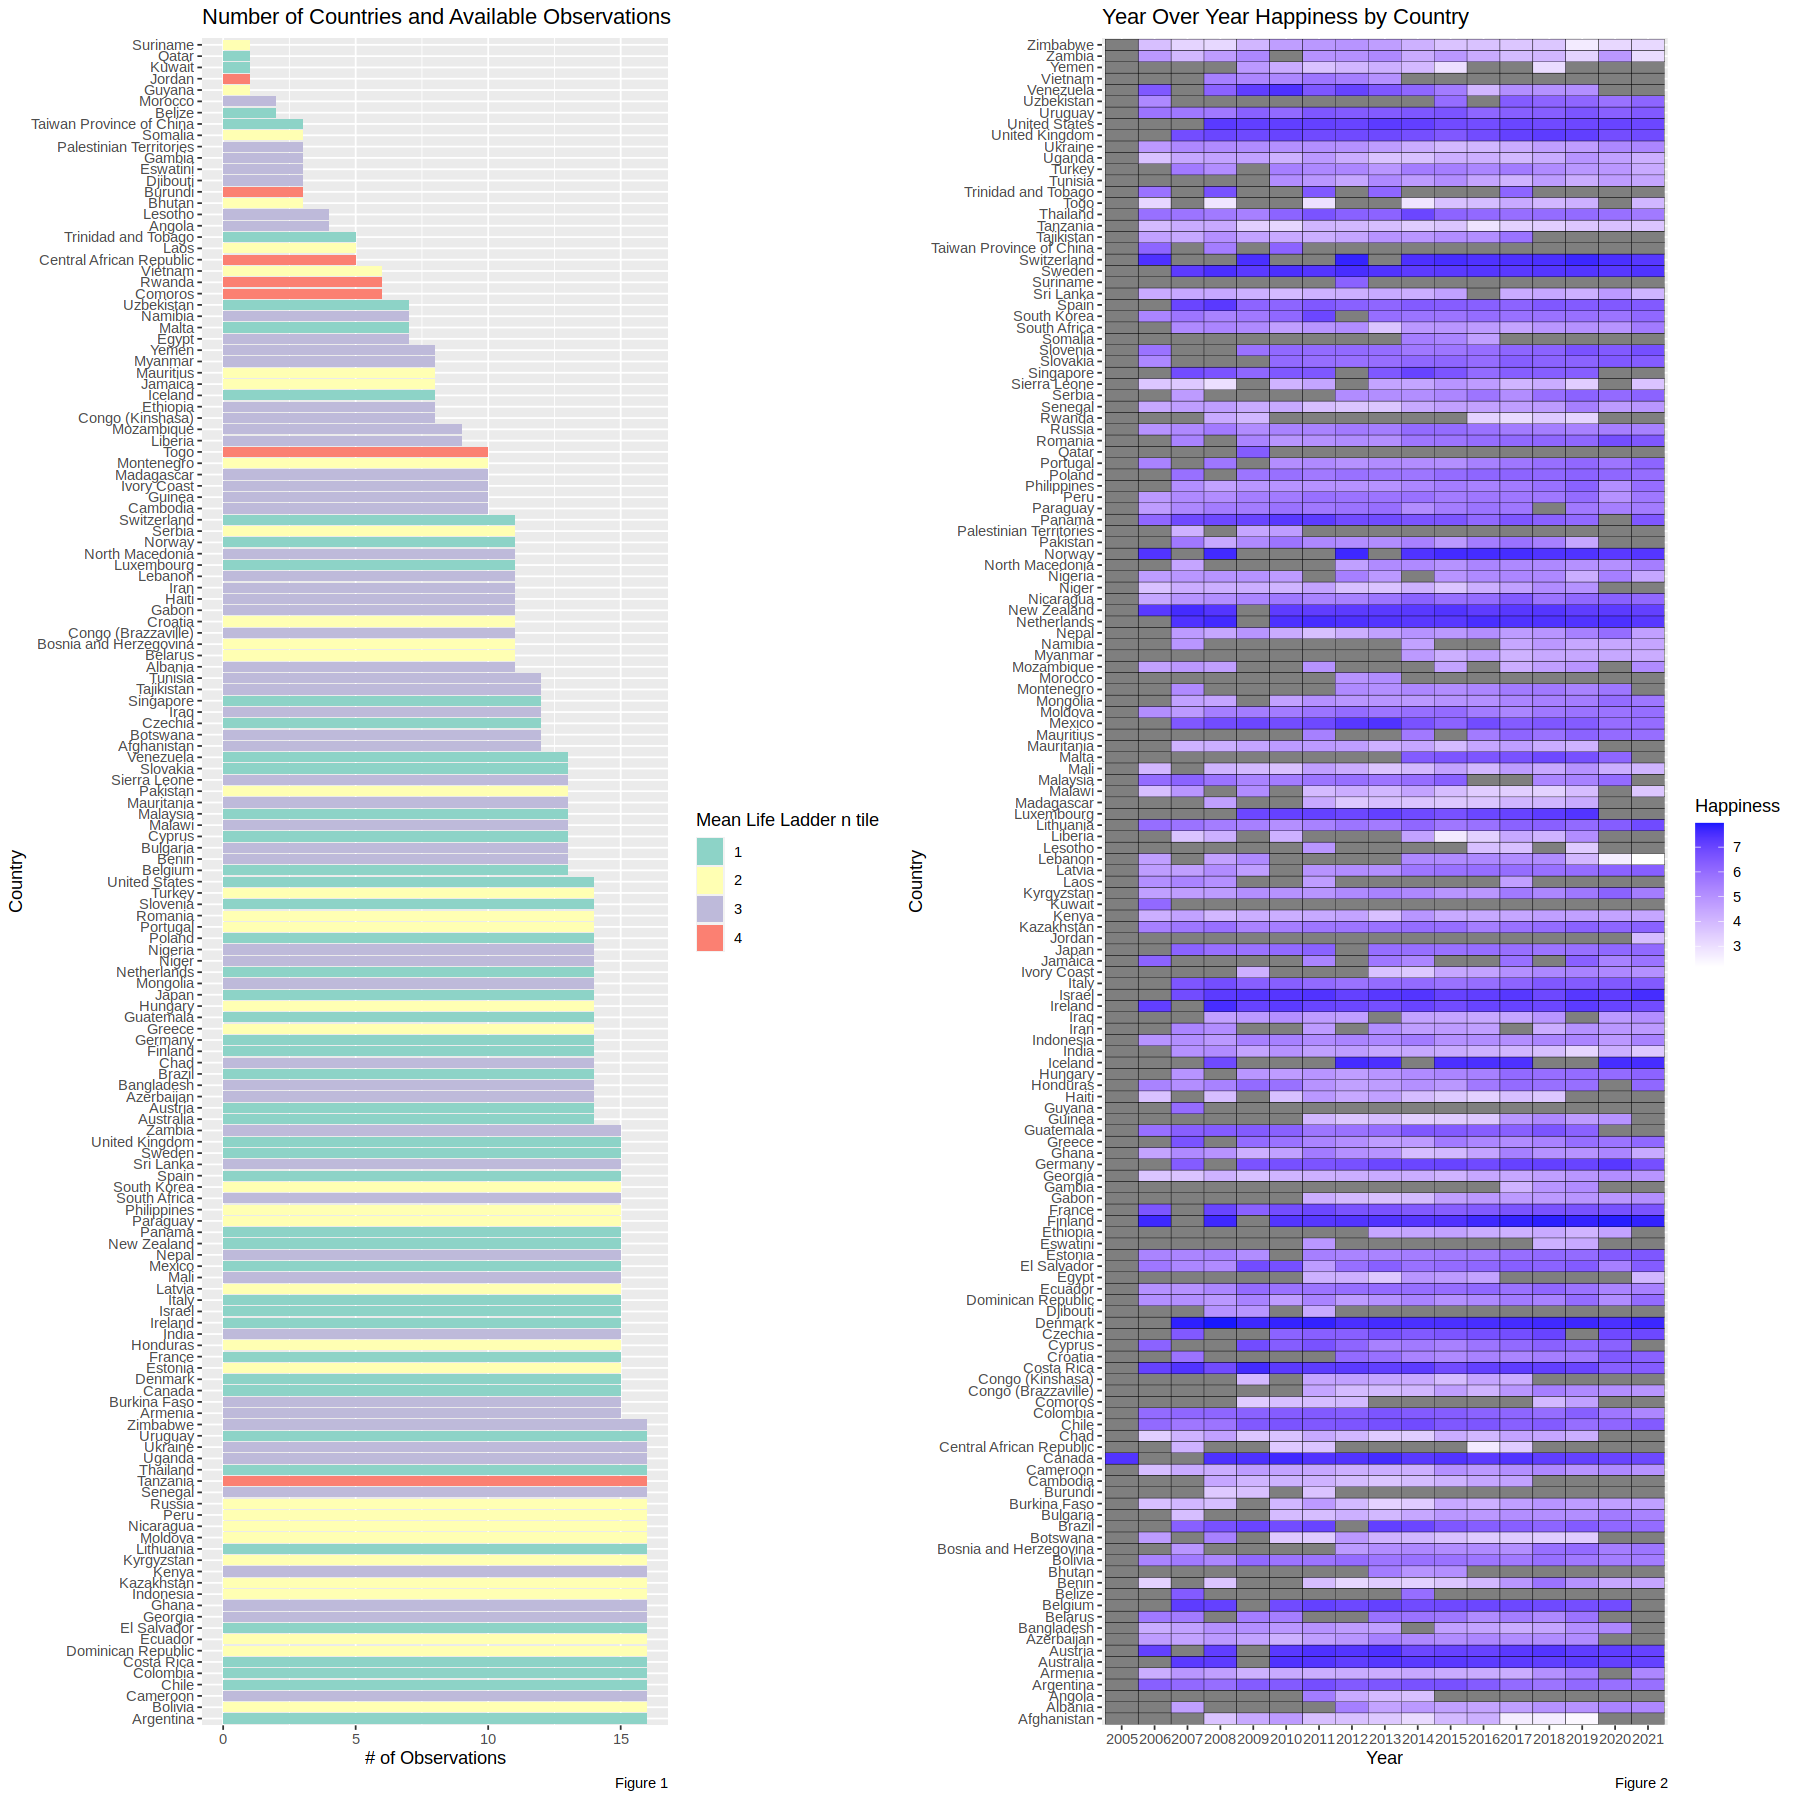

In [3]:
# Number of countries and available data
options(repr.plot.width = 15, repr.plot.height = 15) 

happiness_data_obs <- happiness_data |> 
    group_by(country_name) |> 
    summarize(obs_count=n(),
                mean_cluster = as.integer(mean(life_ladder_ntile))) |>
    arrange(-obs_count) |>
    ggplot(aes(x=obs_count,y=fct_inorder(country_name),fill = factor(mean_cluster))) +
    geom_col() +
    scale_fill_brewer(palette="Set3") +
    labs(x="# of Observations", y="Country", fill="Mean Life Ladder n tile", title="Number of Countries and Available Observations", caption = "Figure 1")

#happiness_data_obs # Chart displayed as a group below

# YoY happiness metric heatmap
happiness_heatmap <- happiness_data_wide_life_ladder |>
    pivot_longer(cols=-country_name,names_to="year",values_to ="life_ladder") |>
    ggplot(aes(x=year, y=country_name)) +
    geom_tile(aes(fill=life_ladder), color="black") +
    scale_fill_gradient(low="white", high="#1818ff") +
    labs(x="Year", y="Country", fill="Happiness", title="Year Over Year Happiness by Country", caption = "Figure 2")

#happiness_heatmap # Chart displayed as a group below
plot_grid(happiness_data_obs,happiness_heatmap,ncol = 2)

### 2019, 2020, 2021 Data ###

In [4]:
# Create a list of countries that have data for 2019 and 2021
country_name_2019_2021  <- happiness_data |>
    group_by(country_name) |>
    filter(year %in% c(2019,2021)) |>
    drop_na() |>
    summarise(n=n()) |>
    filter(n>1) |>
    pull(country_name)

# Select the countries and filter for 2019 and 2021 data
happiness_data_2019_2021 <- happiness_data |>
    filter(country_name %in% country_name_2019_2021,
            year %in% c(2019,2021))

# Summarize the estimates of the parameters (mean and sd) across the groups (2019 and 2021)
happiness_data_2019_2021 |> group_by(year) |> summarise(mean_happiness = mean(life_ladder), sd = sd(life_ladder))

year,mean_happiness,sd
<dbl>,<dbl>,<dbl>
2019,5.737087,1.089441
2021,5.670313,1.138531


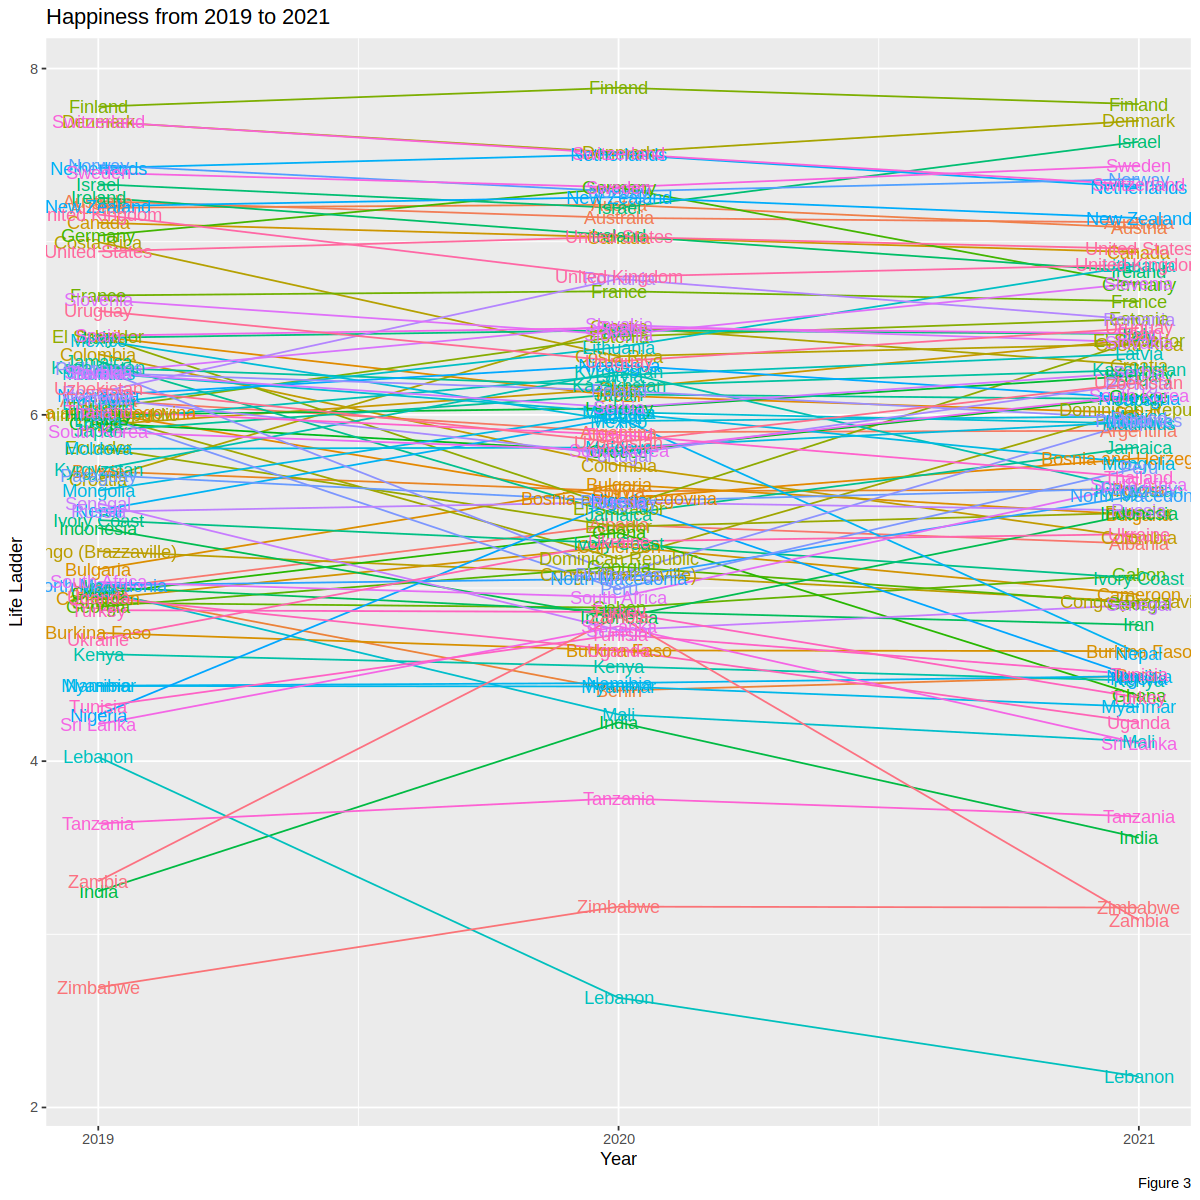

In [5]:
# Change from 2019, 2020, and 2021 happiness
options(repr.plot.width = 10, repr.plot.height = 10)

happiness_trail <- happiness_data_wide_life_ladder |> select(country_name,`2019`,`2020`,`2021`) |> drop_na() |> pivot_longer(cols=-country_name,names_to="year",values_to ="life_ladder") |> mutate(year = as.integer(year)) |>
    ggplot(aes(x=year, y=life_ladder, group=country_name, color=country_name)) +
    geom_line() +
    geom_text(aes(label = country_name)) +
    theme(legend.position="none") +
    labs(x="Year",y="Life Ladder",title="Happiness from 2019 to 2021", caption = "Figure 3") + 
    scale_x_continuous(breaks=c(2019,2020,2021), limits = c(2019,2021))
    
happiness_trail

[1] "Point Estimate (mean change in happiness): -0.0667741624631579"

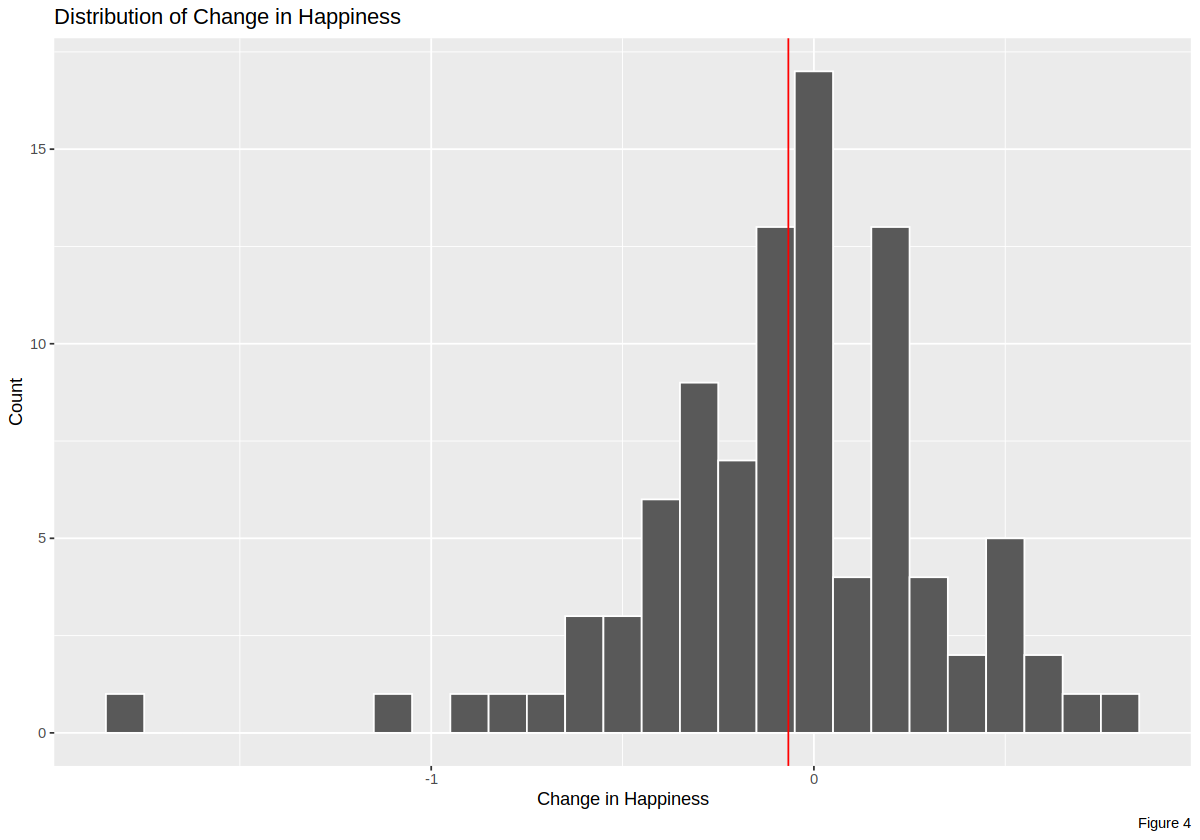

In [6]:
# Change Mean from 2021 to 2019
change_2019_2021 <- happiness_data_wide_life_ladder |>
    select(country_name,`2019`,`2021`) |>
    drop_na() |>
    group_by(country_name) |>
    mutate(change = `2021`-`2019`)

# Mean Change
mean_point_estimate <- mean(change_2019_2021$change)

# Print the mean change
sprintf("Point Estimate (mean change in happiness): %0.16f", mean_point_estimate)

# Plot the Distribution
options(repr.plot.width = 10, repr.plot.height = 7) 
change_2019_2021 |>
    ggplot(aes(x=change)) +
    geom_histogram(binwidth = 0.1, color="white") +
    geom_vline(xintercept=mean(change_2019_2021$change),color="red") +
    labs(x="Change in Happiness",y="Count",title="Distribution of Change in Happiness", caption = "Figure 4")

## Methods
___

**The Good**\
Both the calculated mean change in Happiness and Figure 4 show that the majority of countries did not observe a mean change in happiness greater than 0.5 to -0.5. The report is trustworthy since the data up-to-date and is collected by researchers who have continuously surveyed the same topic for 9 years.

**The Bad**\
While the aforementioned figures provide a good understanding of the mean change in happiness, this is insufficient to report to a stakeholder because we did not report any measures of uncertainty due to variance with our estimate. Furthermore, from the perspective of a stakeholder, it may be best to narrow the countries based on their geographical regions. In figure 4, there are outliers whose happiness has been greatly and negatively impacted compared to the rest of the world. Lastly, our measures of before and after may not be applicable to all countries as COVID-19 is an ongoing pandemic. For the sake of the report, 2019 will be "before COVID-19" and 2021 will be "after COVID-19".

**The Solution**\
To include measures of certainty with our point estimate (mean change in happiness), we will perform hypothesis testing for establishing statistical significance of the results and calculate a confidence interval to quantify the errors when estimating the mean change in happiness between 2019 and 2021.

We will perform a paired T-test because the two datasets sample the same countries over an interval of time. To ensure reproducibility we will use set.seed().

Our hypotheses are the following:  
$$
\begin{align*}
H_0&: \mu_{\text{2021}} - \mu_{\text{2019}} = 0 \qquad \text{(Null Hypothesis: There is no change in mean Happiness before and after COVID-19 throughout countries in the world.)} \\ 
H_1&: \mu_{\text{2021}} - \mu_{\text{2019}} \neq 0 \qquad \text{(Alternative Hypothesis: There is a change in mean Happiness throughout countries in the world)} \\ 
\end{align*}
$$

The significance level will be 0.05 to reasonably reduce the risk of committing a type II error as ignoring the effects of COVID-19 may have greater consequences.

The corresponding confidence level of the confidence interval will be 95% (derived from 1- $\alpha$). We will use the bootstrapping method as this does not require any assumptions about the population distribution; asymptotic approaches *do* require assumptions on the shape of the distribution.

**Expected Findings**\
We expect that COVID-19 decreased happiness levels due to the effects of lockdown; studies done on the effects of vitamin D deficiency (caused due to lack of sunlight) found that it would lead to issues such as depression (3). Staying indoors has been shown to have similar effects (4). This data suggests that COVID would decrease happiness levels. 


**Possible Impacts**\
Happiness is a subjective assessment of an individual’s emotional state or of their life satisfaction. As a result, we believe it is an important metric that could be used to assess government policies. In the case of COVID, utilising happiness as a factor to assess certain policies may have helped the government adjust these policies to the benefit of social welfare. Our findings which assess happiness levels during COVID-19 could be extrapolated to find small shifts in happiness in accordance with certain policies or events - ultimately leading to the ability of happiness to be used as a metric for decision-making (5).

**Future Questions**
* How do countries with different pandemic responses and policies compare in terms of changes in happiness levels?

* How does happiness relate to other indicators of success, such as GDP, and should it be given greater consideration in policymaking? 

## References
___

1. Krys, K., Park, J., Kocimska-Zych, A. et al. (2021). Personal Life Satisfaction as a Measure of Societal Happiness is an Individualistic Presumption: Evidence from Fifty Countries. J Happiness Stud 22, 2197–2214. https://doi.org/10.1007/s10902-020-00311-y

2. Helliwell, J. F., Layard, R., Sachs, J. D., Neve, J.-E. D., Aknin, L. B., & Wang, S. (2021, March 20). World happiness report 2021. https://worldhappiness.report/ed/2021/

3. Anjum, I., Jaffery, S. S., Fayyaz, M., Samoo, Z., Anjum, S., Anjum, I., Jaffery, S. S., Fayyaz, M., Samoo, Z., & Anjum, S. (2018). The role of vitamin d in brain health: A mini literature review. Cureus, 10(7). https://doi.org/10.7759/cureus.2960

4. Thakur, K., Kumar, N., & Sharma, N. (2020). Effect of the pandemic and lockdown on mental health of children. The Indian Journal of Pediatrics, 87(7), 552–552. https://doi.org/10.1007/s12098-020-03308-w

5. Musikanski, L. (2014). Happiness in public policy. Journal of Sustainable Social Change, 6(1). https://scholarworks.waldenu.edu/jsc/vol6/iss1/5
